This is the Beaver's Notebook. We manipulated the data, did some feature engineering, and used a RandomTreeClassifier. We achieved a score of 0.85342.

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import pointbiserialr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We load in the data from the google drive. The training data is the last column so we extract that from the training data first. We then cut off the first column and the last two columns. The first column is the id of the customer which is irrelevant for training. The last column is the classification which is extracted for the testing data. We also take off the TotalCharges column since it was not highly correlated with the outcome and it also had NaN values. We also got the ids of the test data for future use for our submission.csv.

In [ ]:
train_data = pd.read_csv("/content/drive/MyDrive/cs155/train.csv")
y_train = train_data[train_data.columns[-1]]
train_data = train_data.iloc[:, 1:]
train_data = train_data.iloc[:, :-2]
test_data = pd.read_csv("/content/drive/MyDrive/cs155/test.csv")
ids = test_data.iloc[:,0]
test_data = test_data.iloc[:, 1:]
test_data = test_data.iloc[:, :-1]

The next two code blocks were data manipulation. We had to change all string values in the columns to integer values. We changed all No's and Yes's to 0s and 1s. If there were other options, such as No Internet Service, we gave that a value of 2. Additionally, there were other cases that were handled in the same fashion. The same process was done on both the training and testing data.

In [ ]:
train_data.loc[train_data["gender"] == "Male", "gender"] = 1
train_data.loc[train_data["gender"] == "Female", "gender"] = 2

train_data.loc[train_data["Partner"] == "No", "Partner"] = 0
train_data.loc[train_data["Partner"] == "Yes", "Partner"] = 1
train_data.loc[train_data["Dependents"] == "No", "Dependents"] = 0
train_data.loc[train_data["Dependents"] == "Yes", "Dependents"] = 1
train_data.loc[train_data["PhoneService"] == "No", "PhoneService"] = 0
train_data.loc[train_data["PhoneService"] == "Yes", "PhoneService"] = 1
train_data.loc[train_data["MultipleLines"] == "No", "MultipleLines"] = 0
train_data.loc[train_data["MultipleLines"] == "Yes", "MultipleLines"] = 1
train_data.loc[train_data["MultipleLines"] == "No phone service", "MultipleLines"] = 2

train_data.loc[train_data["InternetService"] == "Fiber optic", "InternetService"] = 2
train_data.loc[train_data["InternetService"] == "No", "InternetService"] = 0
train_data.loc[train_data["InternetService"] == "DSL", "InternetService"] = 1

train_data.loc[train_data["OnlineSecurity"] == "No", "OnlineSecurity"] = 0
train_data.loc[train_data["OnlineSecurity"] == "Yes", "OnlineSecurity"] = 1
train_data.loc[train_data["OnlineSecurity"] == "No internet service", "OnlineSecurity"] = 2

train_data.loc[train_data["OnlineBackup"] == "No", "OnlineBackup"] = 0
train_data.loc[train_data["OnlineBackup"] == "Yes", "OnlineBackup"] = 1
train_data.loc[train_data["OnlineBackup"] == "No internet service", "OnlineBackup"] = 2

train_data.loc[train_data["DeviceProtection"] == "Yes", "DeviceProtection"] = 1
train_data.loc[train_data["DeviceProtection"] == "No", "DeviceProtection"] = 0
train_data.loc[train_data["DeviceProtection"] == "No internet service", "DeviceProtection"] = 2

train_data.loc[train_data["TechSupport"] == "Yes", "TechSupport"] = 1
train_data.loc[train_data["TechSupport"] == "No", "TechSupport"] = 0
train_data.loc[train_data["TechSupport"] == "No internet service", "TechSupport"] = 2

train_data.loc[train_data["StreamingTV"] == "Yes", "StreamingTV"] = 1
train_data.loc[train_data["StreamingTV"] == "No", "StreamingTV"] = 0
train_data.loc[train_data["StreamingTV"] == "No internet service", "StreamingTV"] = 2

train_data.loc[train_data["StreamingMovies"] == "Yes", "StreamingMovies"] = 1
train_data.loc[train_data["StreamingMovies"] == "No", "StreamingMovies"] = 0
train_data.loc[train_data["StreamingMovies"] == "No internet service", "StreamingMovies"] = 2

train_data.loc[train_data["Contract"] == "Month-to-month", "Contract"] = 1
train_data.loc[train_data["Contract"] == "One year", "Contract"] = 2
train_data.loc[train_data["Contract"] == "Two year", "Contract"] = 3

train_data.loc[train_data["PaperlessBilling"] == "No", "PaperlessBilling"] = 0
train_data.loc[train_data["PaperlessBilling"] == "Yes", "PaperlessBilling"] = 1

train_data.loc[train_data["PaymentMethod"] == "Electronic check", "PaymentMethod"] = 1
train_data.loc[train_data["PaymentMethod"] == "Mailed check", "PaymentMethod"] = 2
train_data.loc[train_data["PaymentMethod"] == "Bank transfer (automatic)", "PaymentMethod"] = 3
train_data.loc[train_data["PaymentMethod"] == "Credit card (automatic)", "PaymentMethod"] = 4
print(train_data)

     gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0         2              0       0          0       1            1   
1         2              0       0          0      15            1   
2         1              0       1          1      12            1   
3         2              0       0          0      22            1   
4         1              0       0          0       2            0   
...     ...            ...     ...        ...     ...          ...   
5338      2              1       0          1       1            1   
5339      2              0       1          0      72            1   
5340      1              1       0          0       5            1   
5341      1              0       1          1      46            1   
5342      2              1       0          0       3            1   

     MultipleLines InternetService OnlineSecurity OnlineBackup  \
0                0               2              0            0   
1                0         

In [ ]:
test_data.loc[test_data["gender"] == "Male", "gender"] = 1
test_data.loc[test_data["gender"] == "Female", "gender"] = 2

test_data.loc[test_data["Partner"] == "No", "Partner"] = 0
test_data.loc[test_data["Partner"] == "Yes", "Partner"] = 1
test_data.loc[test_data["Dependents"] == "No", "Dependents"] = 0
test_data.loc[test_data["Dependents"] == "Yes", "Dependents"] = 1
test_data.loc[test_data["PhoneService"] == "No", "PhoneService"] = 0
test_data.loc[test_data["PhoneService"] == "Yes", "PhoneService"] = 1
test_data.loc[test_data["MultipleLines"] == "No", "MultipleLines"] = 0
test_data.loc[test_data["MultipleLines"] == "Yes", "MultipleLines"] = 1
test_data.loc[test_data["MultipleLines"] == "No phone service", "MultipleLines"] = 2

test_data.loc[test_data["InternetService"] == "Fiber optic", "InternetService"] = 2
test_data.loc[test_data["InternetService"] == "No", "InternetService"] = 0
test_data.loc[test_data["InternetService"] == "DSL", "InternetService"] = 1

test_data.loc[test_data["OnlineSecurity"] == "No", "OnlineSecurity"] = 0
test_data.loc[test_data["OnlineSecurity"] == "Yes", "OnlineSecurity"] = 1
test_data.loc[test_data["OnlineSecurity"] == "No internet service", "OnlineSecurity"] = 2

test_data.loc[test_data["OnlineBackup"] == "No", "OnlineBackup"] = 0
test_data.loc[test_data["OnlineBackup"] == "Yes", "OnlineBackup"] = 1
test_data.loc[test_data["OnlineBackup"] == "No internet service", "OnlineBackup"] = 2

test_data.loc[test_data["DeviceProtection"] == "Yes", "DeviceProtection"] = 1
test_data.loc[test_data["DeviceProtection"] == "No", "DeviceProtection"] = 0
test_data.loc[test_data["DeviceProtection"] == "No internet service", "DeviceProtection"] = 2

test_data.loc[test_data["TechSupport"] == "Yes", "TechSupport"] = 1
test_data.loc[test_data["TechSupport"] == "No", "TechSupport"] = 0
test_data.loc[test_data["TechSupport"] == "No internet service", "TechSupport"] = 2

test_data.loc[test_data["StreamingTV"] == "Yes", "StreamingTV"] = 1
test_data.loc[test_data["StreamingTV"] == "No", "StreamingTV"] = 0
test_data.loc[test_data["StreamingTV"] == "No internet service", "StreamingTV"] = 2

test_data.loc[test_data["StreamingMovies"] == "Yes", "StreamingMovies"] = 1
test_data.loc[test_data["StreamingMovies"] == "No", "StreamingMovies"] = 0
test_data.loc[test_data["StreamingMovies"] == "No internet service", "StreamingMovies"] = 2

test_data.loc[test_data["Contract"] == "Month-to-month", "Contract"] = 1
test_data.loc[test_data["Contract"] == "One year", "Contract"] = 2
test_data.loc[test_data["Contract"] == "Two year", "Contract"] = 3

test_data.loc[test_data["PaperlessBilling"] == "No", "PaperlessBilling"] = 0
test_data.loc[test_data["PaperlessBilling"] == "Yes", "PaperlessBilling"] = 1

test_data.loc[test_data["PaymentMethod"] == "Electronic check", "PaymentMethod"] = 1
test_data.loc[test_data["PaymentMethod"] == "Mailed check", "PaymentMethod"] = 2
test_data.loc[test_data["PaymentMethod"] == "Bank transfer (automatic)", "PaymentMethod"] = 3
test_data.loc[test_data["PaymentMethod"] == "Credit card (automatic)", "PaymentMethod"] = 4
print(test_data)

     gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0         2              0       1          1      17            1   
1         1              0       0          0       1            1   
2         1              1       0          0      38            1   
3         1              0       0          0       2            1   
4         2              0       0          0      47            1   
...     ...            ...     ...        ...     ...          ...   
1695      1              0       0          0      45            0   
1696      2              0       0          0       2            1   
1697      1              0       1          1      72            1   
1698      2              0       1          1      34            1   
1699      2              0       0          0       1            1   

     MultipleLines InternetService OnlineSecurity OnlineBackup  \
0                1               2              0            0   
1                0         

This next code block was used to determine the most important features to improve the performance of our model. We first used the import pointbiserialr to determine the correlation between each column and the binary outcome. The values are printed below and a graph is included. Additionally, we ran a Lasso to learn the coefficients to minimize its loss function. The mixture of both these methods led to us focusing on ten of features of the previous eightteen features. Our output printed below led us to choose: ['SeniorCitizen', 'tenure', 'InternetService', 'OnlineSecurity', 'TechSupport', 'StreamingTV', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges'] for our model.

gender
0.00961029820610227
SeniorCitizen
0.15266391832719634
Partner
-0.15031283142771348
Dependents
-0.165445808200049
tenure
-0.3444290953270096
PhoneService
0.015894602177205563
MultipleLines
0.017493929098951883
InternetService
0.3155764073480813
OnlineSecurity
-0.3293826130992465
OnlineBackup
-0.289564015966617
DeviceProtection
-0.2798456092616637
TechSupport
-0.3290983816008591
StreamingTV
-0.19554250290303832
StreamingMovies
-0.20839333474678212
Contract
-0.3906667600063297
PaperlessBilling
0.1898879276485652
PaymentMethod
-0.2565010020547408
MonthlyCharges
0.19716530370330354


Text(0.5, 1.0, 'Biserial Correlations vs. Data Type')

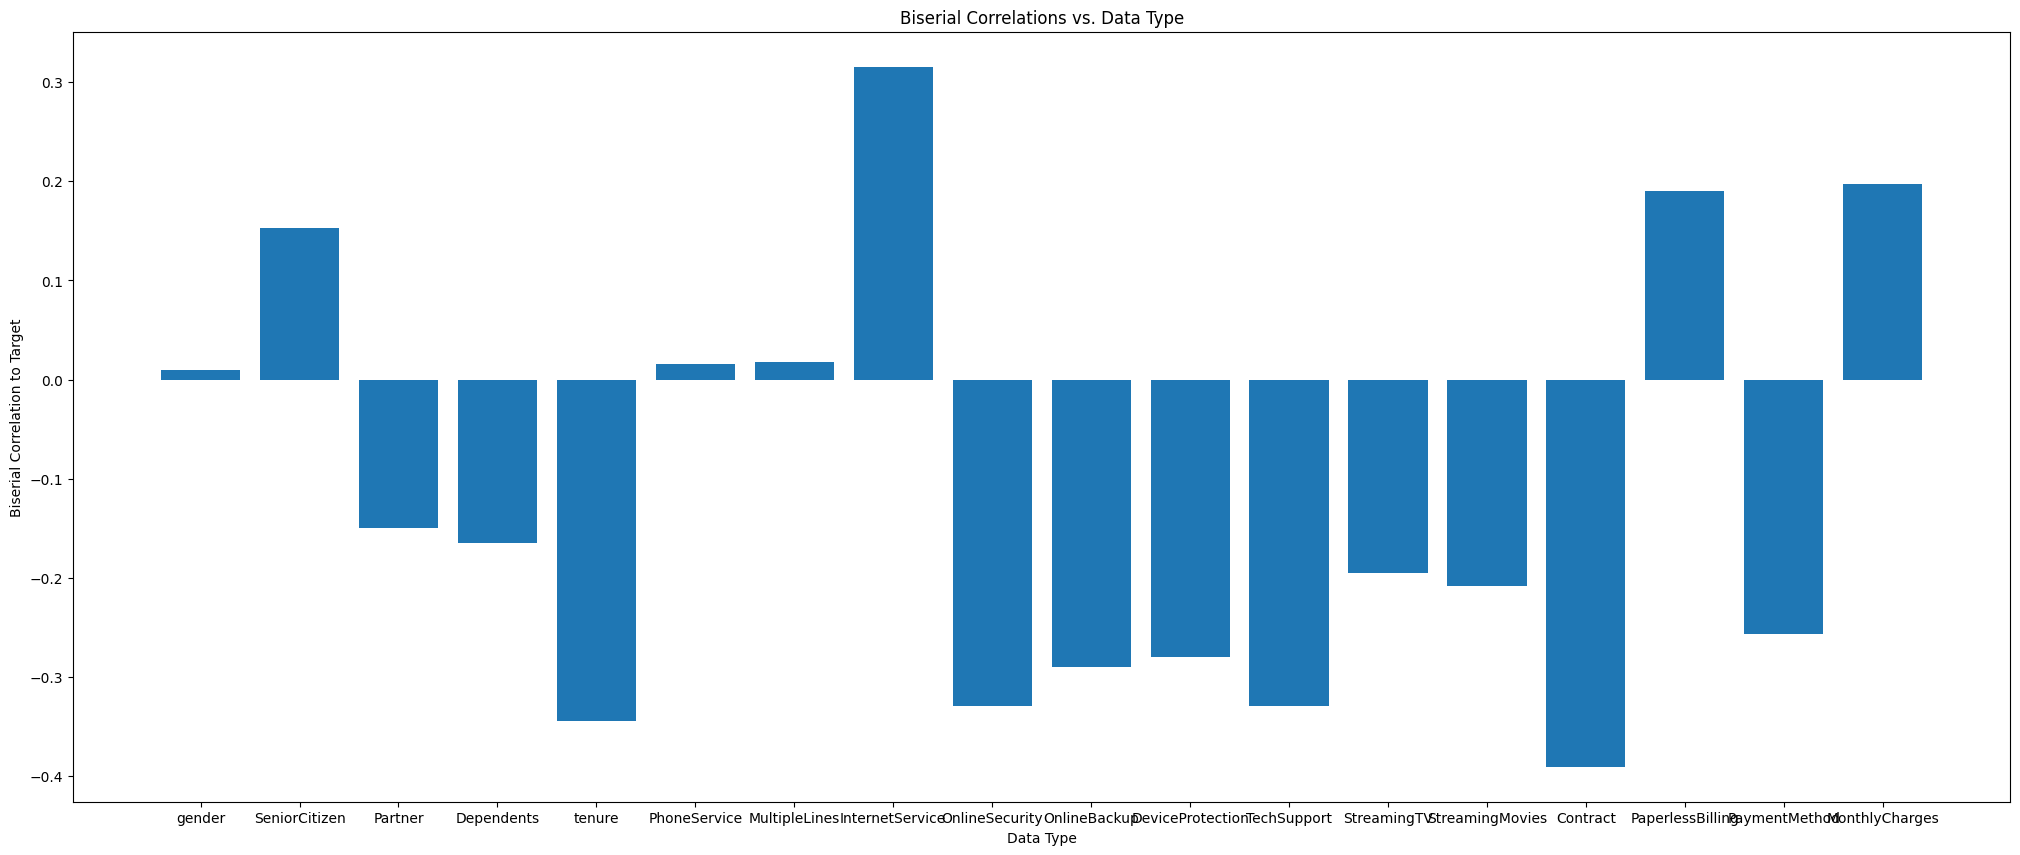

In [ ]:
features = []
correlations = []

for column in train_data.columns:
    y_train[y_train == 'Yes'] = 1
    y_train[y_train == 'No'] = 0
    corr, val = pointbiserialr(train_data[column], y_train)
    print(column)
    print(corr)
    features.append(column)
    correlations.append(corr)

plt.figure(figsize = (25,10))
plt.bar(features, correlations)
plt.xlabel("Data Type")
plt.ylabel("Biserial Correlation to Target")
plt.title("Biserial Correlations vs. Data Type")

<BarContainer object of 18 artists>

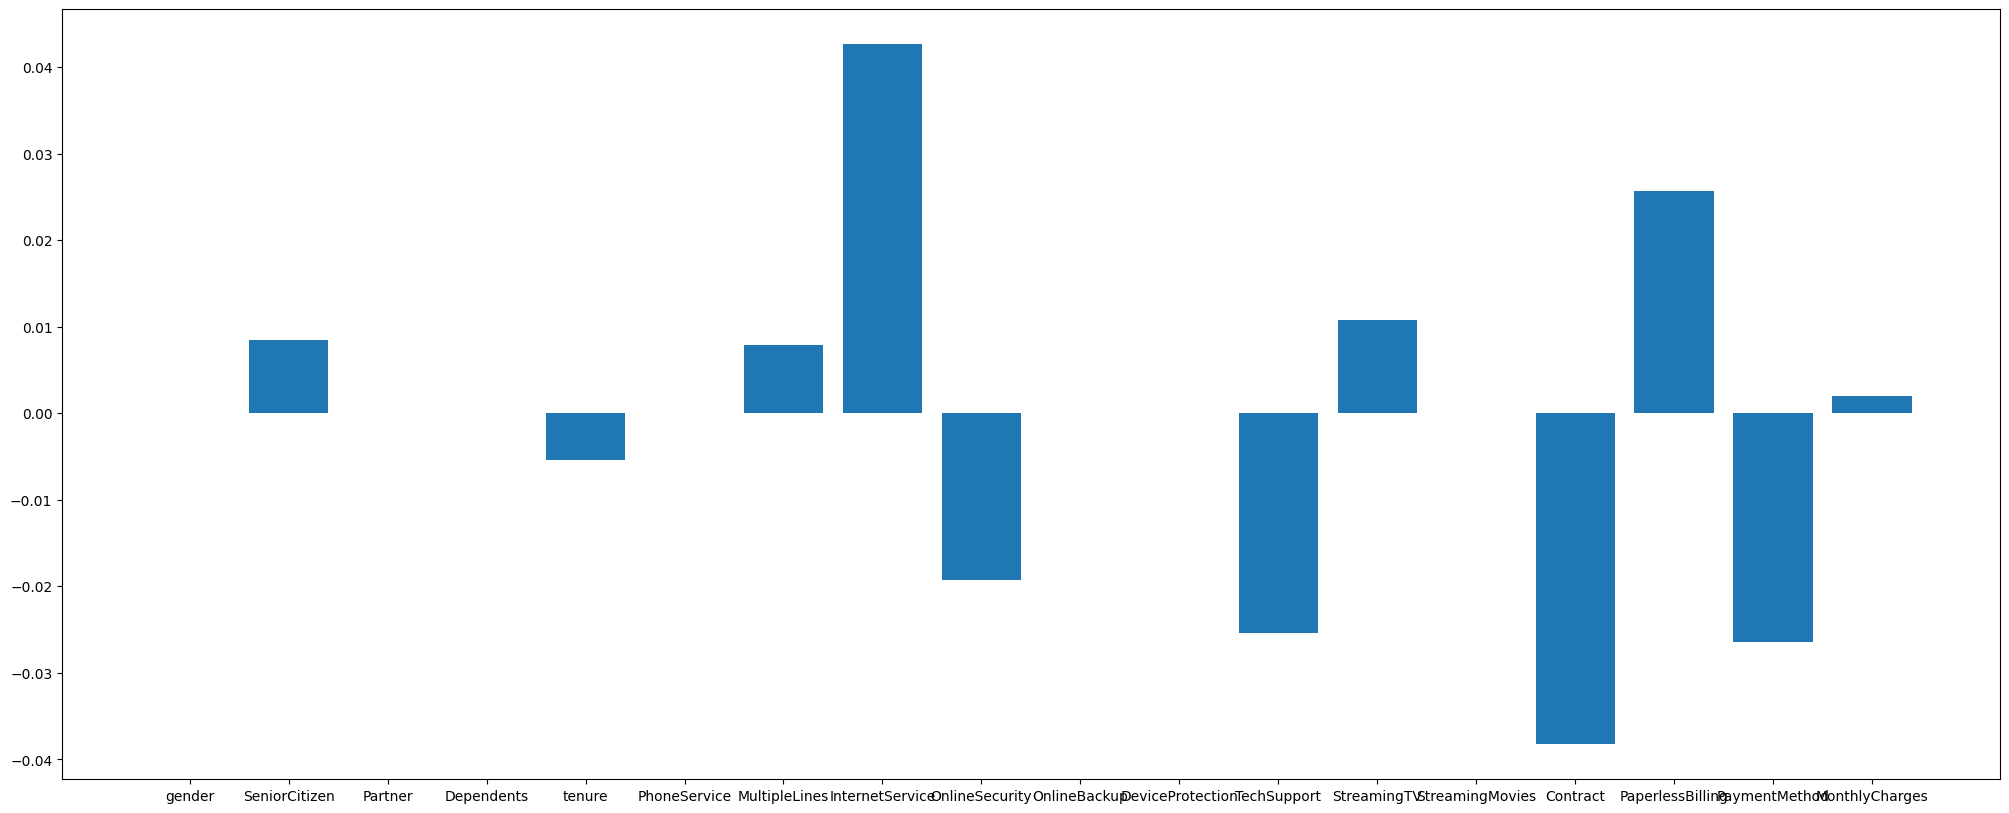

In [ ]:
model = Lasso(alpha = .01)

model.fit(train_data, y_train)

plt.figure(figsize = (25, 10))
plt.bar(train_data.columns, model.coef_)

Below is a way that we went about choosing the best parameters along with individually training. We developed a heat map with the min_samples_leaf on the y-axis and max_depth on the x-axis. The darker the score the lower the testing error. The lower values when min_samples_leaf is around 8 is most likely overfitting. We attempted to submit with potential values and evaluated the out of sample performance for each. We chose the optimal parameters to be max_depth = 30 and min_samples_leaf = 15.

<Axes: >

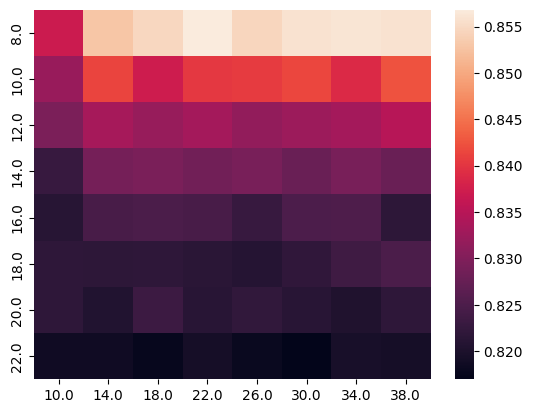

In [ ]:
heat = np.ones((8, 8))

ind = np.linspace(8, 22, 8)
col = np.linspace(10, 38, 8)

for i in range(0, 8):
  for n in range(0, 8):
    leaf = i * 2 + 5
    depth = n * 4 + 10

    grid_model = RandomForestClassifier(n_estimators = 80, max_depth = depth, min_samples_leaf = leaf)
    grid_model.fit(train_data[['SeniorCitizen', 'tenure', 'InternetService', 'OnlineSecurity', 'TechSupport', 'StreamingTV', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges']], y_train.astype("int"))
    preds = grid_model.predict(train_data[['SeniorCitizen', 'tenure', 'InternetService', 'OnlineSecurity', 'TechSupport', 'StreamingTV', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges']])
    heat[i, n] = (accuracy_score(preds, y_train.astype("int")))


heat = pd.DataFrame(heat, index = ind, columns = col)

plt.ylabel('min_sample_leaf')
plt.xlabel('max_depth')
sns.heatmap(heat)

In [ ]:
print(heat)

          10.0      14.0      18.0      22.0      26.0      30.0      34.0  \
8.0   0.836983  0.852892  0.854763  0.856822  0.854576  0.855886  0.856073   
10.0  0.832117  0.841288  0.837170  0.840165  0.840539  0.841475  0.838855   
12.0  0.829497  0.833427  0.831930  0.833240  0.831555  0.832491  0.833240   
14.0  0.822759  0.828935  0.829309  0.828561  0.829122  0.827812  0.829122   
16.0  0.821074  0.824443  0.824818  0.824443  0.822759  0.825005  0.825192   
18.0  0.821823  0.821636  0.821823  0.821449  0.820887  0.822010  0.823507   
20.0  0.821823  0.820513  0.823320  0.821261  0.822197  0.821261  0.820326   
22.0  0.818641  0.818641  0.817705  0.819203  0.817893  0.816957  0.819577   

          38.0  
8.0   0.855886  
10.0  0.842411  
12.0  0.834924  
14.0  0.827812  
16.0  0.821636  
18.0  0.824818  
20.0  0.821823  
22.0  0.819203  


Below is our model specifics. We tested on various parameters of the RandomForestClassifier and landed on these parameters specifically. We fit the data from the input data from the ten most important columns and the classifications as the output. We then predicted the probability for the binary classification using the model for the test data. Used the function predict_proba which outputs the probability that it is 0 and the probability that it is 1. The length of the predicted values is 1700 as desired. The accuracy score for the training data was around 0.822.

In [ ]:
model = RandomForestClassifier(n_estimators = 75, max_depth = 30, min_samples_leaf = 15)

model.fit(train_data[['SeniorCitizen', 'tenure', 'InternetService', 'OnlineSecurity', 'TechSupport', 'StreamingTV', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges']], y_train.astype("int"))

preds = model.predict(train_data[['SeniorCitizen', 'tenure', 'InternetService', 'OnlineSecurity', 'TechSupport', 'StreamingTV', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges']])

y_pred = model.predict_proba(test_data[['SeniorCitizen', 'tenure', 'InternetService', 'OnlineSecurity', 'TechSupport', 'StreamingTV', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges']])
print(y_pred)
print(len(y_pred))

print(accuracy_score(preds, y_train.astype("int")))

[[0.48832925 0.51167075]
 [0.71047683 0.28952317]
 [0.55294929 0.44705071]
 ...
 [0.98321474 0.01678526]
 [0.98261275 0.01738725]
 [0.58355864 0.41644136]]
1700
0.8220101066816395


Below is the code that is used to save our predictions to a csv file.

In [ ]:
df = pd.DataFrame({'ID': ids, 'Values' : y_pred[:,1]})
print(df)
df.to_csv('submission.csv', index = False)

              ID    Values
0     0378-NHQXU  0.511671
1     4745-LSPLO  0.289523
2     5144-TVGLP  0.447051
3     3422-GALYP  0.812647
4     5630-IXDXV  0.595573
...          ...       ...
1695  7795-CFOCW  0.042718
1696  0396-HUJBP  0.170672
1697  3892-NXAZG  0.016785
1698  3957-SQXML  0.017387
1699  4897-QSUYC  0.416441

[1700 rows x 2 columns]
